In [25]:
from astropy.table import Table
from astropy.io import fits
from astropy import units as u

import os

import matplotlib
import matplotlib.pyplot as plt

from scipy.integrate import trapezoid
from scipy.ndimage import uniform_filter1d
from scipy import interpolate 

import numpy as np
import pandas as pd

import tqdm

import pickle

<div class="alert alert-block alert-danger">
    <span style='font-size:18px'>
    The numbers in this notebook is only for forecast!
    </span>    
</div>

# <span style='color:DarkSlateBlue'> Define filter sets - telescope, detectors, filters, efficiencies </span>

### Define top-hat like filter transmission curve

<!-- * [Filter information](edmundoptics.co.kr/f/hard-coated-od-4-25nm-bandpass-filters/14529/) -->

In [3]:
# Top-hat like filter transmission curve
def tophat_trans(x, center=0, fwhm=1, smoothness=0.2):

    from scipy.special import erf, erfc
    
    t_left  = erfc(+((2*(x-center)/fwhm)-1)/smoothness)/2 
    t_right = erfc(-((2*(x-center)/fwhm)+1)/smoothness)/2
    
    return (t_left*t_right)

In [4]:
# lambda_7ds = np.arange(4000., 9000., 250)
lambda_7ds = np.arange(4000., 9000., 125)

filters_original = {}

for ii, wl_cen in enumerate(lambda_7ds):
    fwhm = 250 #anstrom
    wave_lvf = np.linspace(0.1, 1.0, 1001)
    resp_lvf = tophat_trans(wave_lvf, center=wl_cen/1e4, fwhm=fwhm/1e4)
    
    wave_cen = f'{int(wl_cen):d}'
    
    filters_original['wave_' + wave_cen] = wave_lvf
    filters_original['resp_' + wave_cen] = resp_lvf

### Telescope

* Twenty 0.5m telescopes, f/3
* Planewave DR500 model

In [5]:
D = 50.8             # Aperture size [cm]
D_obscuration = 29.8   # Central Obscuration (diameter) [cm]
EFL = 1537.3           # Effective FL [mm]

Deff = np.sqrt(D**2 - D_obscuration**2)
Deff

41.14122020553109

### Detectors
<!-- * Moravian Camera: [C3-61000PRO](https://www.gxccd.com/art?id=647&lang=409) -->
    - equipped with Sony IMX455 rolling shutter ***back-illuminated*** CMOS detectors
    - Resolution: 9576 x 6388
    - Pixel Size: 3.76 x 3.76 um
    - Sensor Size: 63.01 x 24.02 mm

  
<!-- * Optics table, [QE from Sony IMX455 chips](https://docs.google.com/spreadsheets/d/1FDCVZCerRWBySbJuMX35Lu4jVJsBGGdjXEET0v0afrQ/edit?usp=sharing) -->

### Conversion factors and read-out noise

Generally, many sensor characteristics depend on the used gain. Also, the used sensors employ two conversion paths. One path offers very low read noise, but cannot utilize full sensor dynamic range. Another conversion path offers maximum pixel capacity, but at the price of higher read noise. 

`The cross point is set to gain 3x (approx. 10 dB), where the full well capacity drops from more than 50 ke- to ~17 ke-. The read noise then drops from ~3.2 e- RMS to ~1.5 e- RMS.`


|Gain number|Gain multiply|Conversion factor|Read noise RMS|Full well capacity|
|------|------|------|------|------|
|0|1x|0.80e-/ADU|3.51e-|52800e-|
|2749|3x|0.26e-/ADU|3.15e-|17100e-|
|2750|3x|0.26e-/ADU|1.46e-|16900e-|
|4030|63x|0.18e-/ADU|1.39e-|11600e-|

In [6]:
array = 'CMOS'       # detector array type - verified, websete
dQ_RN = 3.           # [e], readout noise - estimated, websete
I_dark = 0.01        # [e/s], dark current - seems to be very low ???
pixel_size = 3.76    # [um], "pitch" - verified, websete
theta_pixel = pixel_size / EFL * 206.265  # [arcsec], pixel scale- estimated, websete 
nxpix, nypix = 9576, 6388  # [pixels], detector format, approx. 9k x 6k - verified, websete

Text(0.5, 1.0, 'IMX455 Sensor')

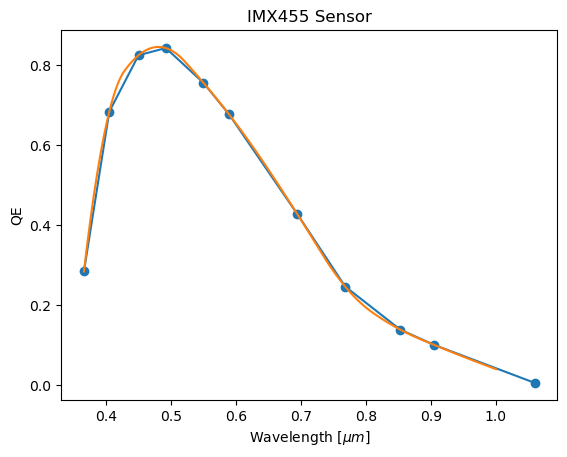

In [7]:
# from IMX455 table (ecvs) 
# qe_lam = [366, 400, 405, 450, 492, 500, 550, 589, 600, 694, 700, 768, 800, 835, 900, 905, 1000, 1060]
# qe_tot = [28.5, 67.34, 68.4, 82.5, 84.3, 88.46, 75.6, 67.8, 89.17, 42.9, 82.38, 24.7, 62.95, 13.9, 49.20, 10.1, 42.41, 0.6]

qe_lam = [366, 405, 450, 492, 550, 589, 694, 768, 853, 905, 1060]
qe_lam = np.array(qe_lam) / 1000
qe_tot = [28.5, 68.4, 82.5, 84.3, 75.6, 67.8, 42.9, 24.7, 13.9, 10.1, 0.6]
qe_tot = np.array(qe_tot) / 100

T_qe = Table([qe_lam, qe_tot], names = ['wavelength', 'QE'])
T_qe['wavelength'].unit = u.um
T_qe['wavelength'].format = '8.4f'

fig, ax = plt.subplots()
ax.plot(T_qe['wavelength'], T_qe['QE'], 'o-')

# for polynomial interpolation
ref_lambdas = np.linspace(0.366, 1.0, 1001) #um
smooth_qe = interpolate.interp1d(T_qe['wavelength'], T_qe['QE'], kind = 'quadratic')
ax.plot(ref_lambdas, smooth_qe(ref_lambdas), '-')

ax.set_xlabel('Wavelength [$\mu m$]')
ax.set_ylabel('QE')
ax.set_title('IMX455 Sensor')

### Efficiency

* wavelength dependent efficiency for DR350/500

Lens-1: H-K9LA, 19mm thickness
Lens-2: H-LAK4L, 10mm thickness
Lens-3: H-FK95N, 22.6mm thickness

VIS = Standard (VIS) BBAR Coating 101-400-700

Al coating = Enhanced Al Mirror Coating

|nm|H-K9LA|H-LaK4L|H-FK95N|VIS|Al coating|Total|
|------|------|------|------|------|------|------|
|400|0.997|0.974|0.996|0.988|0.86|67.34|
|500|0.997|0.995|0.998|0.998|0.95|88.46|
|600|0.998|0.997|0.998|0.999|0.95|89.17|
|700|0.998|0.997|0.998|0.996|0.92|82.38|
|800|0.998|0.998|0.998|0.974|0.85|62.95|
|900|0.998|0.998|0.998|0.936|0.83|49.20|
|1000|0.998|0.998|0.998|0.900|0.85|42.41|

(H-K9LA, 10mm @400nm) * (H-LaK4L, 10mm @400nm) * (H-FK95N, 10mm @400nm) * VIS^5 * Al coating^2 ~ total

In [8]:
eff_lambdas = np.arange(400, 1100, 100) / 1000 #um
eff_lens1 = np.array([0.997, 0.997, 0.998, 0.998, 0.998, 0.998, 0.998])
eff_lens2 = np.array([0.974, 0.995, 0.997, 0.997, 0.998, 0.998, 0.998])
eff_lens3 = np.array([0.996, 0.998, 0.998, 0.998, 0.998, 0.998, 0.998])
eff_vis = np.array([0.988, 0.998, 0.999, 0.996, 0.974, 0.936, 0.900])
eff_al = np.array([0.86, 0.95, 0.95, 0.92, 0.85, 0.83, 0.85])

# Optics
eff_optics = eff_lens1 * eff_lens2 * eff_lens3 * eff_vis**5 * eff_al**2
# Smooth Optics
ref_lambdas = np.linspace(0.366, 1.0, 1001) #um
smooth_opt = interpolate.interp1d(eff_lambdas, eff_optics, kind = 'quadratic')
eff_optics_smooth = np.interp(ref_lambdas, np.linspace(0.4, 1, 1001), smooth_opt(np.linspace(0.4, 1, 1001)))


# CMOS QE
eff_fpa = np.interp(eff_lambdas, T_qe['wavelength'], T_qe['QE'])
# Smooth QE
eff_fpa_smooth = smooth_qe(ref_lambdas)


#  Total Efficeincy
eff_total = eff_optics * eff_fpa
# Smooth total efficiency
eff_total_smooth = eff_optics_smooth * eff_fpa_smooth


In [10]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


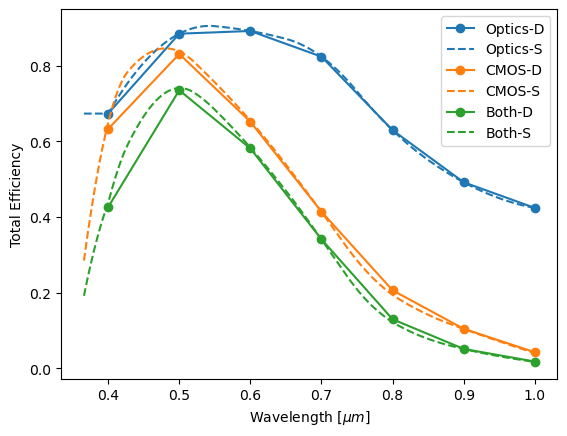

In [11]:
fig, ax = plt.subplots()

ax.plot(eff_lambdas, eff_optics, 'o-', label = 'Optics-D', color = '#1f77b4')
ax.plot(ref_lambdas, eff_optics_smooth, '--', label = 'Optics-S', color = '#1f77b4')

ax.plot(eff_lambdas, eff_fpa, 'o-', label = 'CMOS-D', color = '#ff7f0e')
ax.plot(ref_lambdas, eff_fpa_smooth, '--', label = 'CMOS-S', color = '#ff7f0e')

ax.plot(eff_lambdas, eff_total, 'o-', label = 'Both-D', color = '#2ca02c')
ax.plot(ref_lambdas, eff_total_smooth, '--', label = 'Both-S', color = '#2ca02c')

ax.set_xlabel('Wavelength [$\mu m$]')
ax.set_ylabel('Total Efficiency')

ax.legend()

### Atmospheric transmission
- Site dependent!
- Model for Paranal site (VLT)
    <!-- - https://www.eso.org/sci/software/pipelines/skytools/skycalc -->
    - Run web-based calculator with 
        - `airmass = 1.3`
        - `PWV` = 2.5mm (very good, not critical in the optical)
        - `$\lambda_{min}$ =  300nm`
        - `$\lambda_{min}$ = 5000nm`
        - `Logarithmic binning` λ/Δλ = 20000 (default; decrease to save time and space)
        - Check `Calculate Broad-Band`

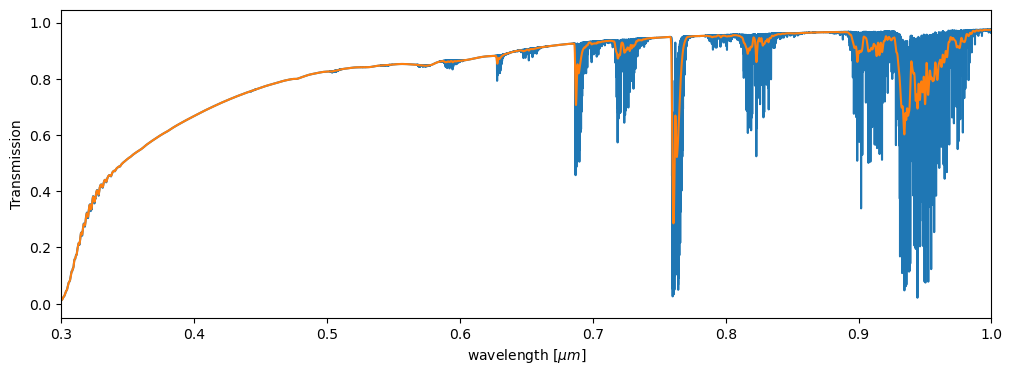

In [18]:
sky_tbl = Table.read('../../data/systematics/skytable.fits')

plt.figure(figsize=(12,4))
plt.plot(sky_tbl['lam']/1e3, sky_tbl['trans'])
plt.xlabel('wavelength [$\mu m$]')
plt.ylabel('Transmission')
plt.xlim(0.3, 1)

from scipy.ndimage import gaussian_filter
trans_smooth = gaussian_filter(sky_tbl['trans'], 10)
plt.plot(sky_tbl['lam']/1e3, trans_smooth)

### Final Filter Transmission Curve

In [22]:
filters_corrected = {}

for ii, wl_cen in enumerate(lambda_7ds):
    
    
    wave_cen = f'{int(wl_cen):d}'
    
    wave_lvf = filters_original['wave_' + wave_cen]
    resp_lvf = filters_original['resp_' + wave_cen]
    
    
    resp_sys = resp_lvf.copy()
    
    ### consider efficiencies
    intp_qe = np.interp(wave_lvf, ref_lambdas, eff_total_smooth)
    intp_trans = np.interp(wave_lvf, sky_tbl['lam']*1e-3, trans_smooth)
    
    #sky & CMOS QE
    resp_sys = resp_sys * intp_qe * intp_trans 
    
    filters_corrected['wave_' + wave_cen] = wave_lvf
    filters_corrected['resp_' + wave_cen] = resp_sys
    

Text(0, 0.5, 'Response')

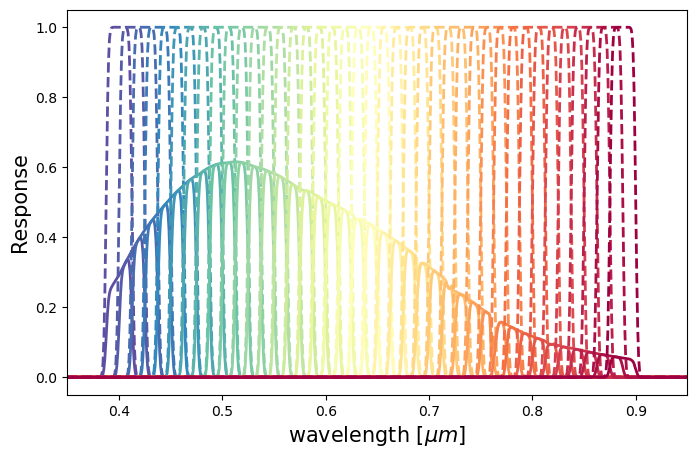

In [23]:
colors = plt.cm.Spectral(np.linspace(1, 0, 40))

fig, ax = plt.subplots(figsize = (8, 5))

for ii, wl_cen in enumerate(lambda_7ds):
    
    
    wave_cen = f'{int(wl_cen):d}'
    
    wave_ori = filters_original['wave_' + wave_cen]
    resp_ori = filters_original['resp_' + wave_cen]
    
    wave_cor = filters_corrected['wave_' + wave_cen]
    resp_cor = filters_corrected['resp_' + wave_cen]
    
    ax.plot(wave_ori, resp_ori, color = colors[ii], linewidth = 2, linestyle = '--')
    ax.plot(wave_cor, resp_cor, color = colors[ii], linewidth = 2)
    
ax.set_xlim(0.35, 0.95)

ax.set_xlabel('wavelength [$\mu m$]', fontsize = 15)
ax.set_ylabel('Response', fontsize = 15)

# fig.savefig('./figs/filter_resp.png')

In [26]:
# with open('filters_original','wb') as fw:
#     pickle.dump(filters_original, fw)

# with open('filters_corrected','wb') as fw:
#     pickle.dump(filters_corrected, fw)